In [1]:
import numpy as np
from vqls_prototype import VQLS, VQLSLog
from qiskit.primitives import Estimator 
from vqls_prototype.hadamard_test import BatchHadammardTest

In [2]:
N = 8
A = np.random.rand(N,N)
A = A + A.T 

# A = np.loadtxt('./matrix_linear/4linear.mat')
# A /= np.linalg.norm(A)
 
b = np.random.rand(N)
b /= np.linalg.norm(b)

In [3]:
from qiskit.circuit.library.n_local.real_amplitudes import RealAmplitudes
from qiskit.circuit.library.n_local.efficient_su2 import EfficientSU2
num_qubits = int(np.log2(N))
ansatz = RealAmplitudes(num_qubits, entanglement='full', reps=2, insert_barriers=False)
# ansatz = EfficientSU2(num_qubits, reps=1, entanglement='reverse_linear', insert_barriers=False)

In [4]:
from qiskit.algorithms import optimizers as opt
optimizer = opt.COBYLA(maxiter=250)

In [5]:
num_parameters = ansatz.num_parameters
parameters = np.random.rand(num_parameters)

# Cost evaulation Pauli

In [6]:
log = VQLSLog([], [])
estimator_noisefree = Estimator()
vqls = VQLS(estimator_noisefree, ansatz, optimizer,callback=log.update)
vqls_options = vqls._validate_solve_options({"matrix_decomposition":'pauli', 
                                             'shots':None})
hdmr_tests_norm, hdmr_tests_overlap = vqls.construct_circuit(A, b, vqls_options)
coefficient_matrix = vqls.get_coefficient_matrix(
    np.array([mat_i.coeff for mat_i in vqls.matrix_circuits])
)

cost_evaluation = vqls.get_cost_evaluation_function(
    hdmr_tests_norm, hdmr_tests_overlap, coefficient_matrix, vqls_options
)

cost_value = cost_evaluation(parameters)

# Cost Evaluation Contracted Pauli

In [7]:
log = VQLSLog([], [])
estimator_noisefree = Estimator()
vqls = VQLS(estimator_noisefree, ansatz, optimizer,callback=log.update)
vqls_options = vqls._validate_solve_options({"matrix_decomposition":'contracted_pauli', 
                                             'shots':None})
hdmr_tests_norm, hdmr_tests_overlap = vqls.construct_circuit(A, b, vqls_options)
coefficient_matrix = vqls.get_coefficient_matrix(
    np.array([mat_i.coeff for mat_i in vqls.matrix_circuits])
)

cost_evaluation = vqls.get_cost_evaluation_function(
    hdmr_tests_norm, hdmr_tests_overlap, coefficient_matrix, vqls_options
)

cost_value = cost_evaluation(parameters)

# Measurement OPtimization

In [8]:
from vqls_prototype.matrix_decomposition import ContractedPauliDecomposition 
PD = ContractedPauliDecomposition(A)

In [9]:
qwc_groups, qwc_groups_eigenvalues, qwc_groups_shared_basis_transformation = PD.group_contracted_terms()

In [10]:
qwc_groups[0]

['XXX', 'IXX', 'XIX', 'XXI', 'IIX', 'IXI', 'XII']

In [11]:
qwc_groups_eigenvalues[0]

[array([ 1, -1, -1,  1, -1,  1,  1, -1]),
 array([ 1, -1, -1,  1,  1, -1, -1,  1]),
 array([ 1, -1,  1, -1, -1,  1, -1,  1]),
 array([ 1,  1, -1, -1, -1, -1,  1,  1]),
 array([ 1, -1,  1, -1,  1, -1,  1, -1]),
 array([ 1,  1, -1, -1,  1,  1, -1, -1]),
 array([ 1,  1,  1,  1, -1, -1, -1, -1])]

In [12]:
qwc_groups_shared_basis_transformation[0]

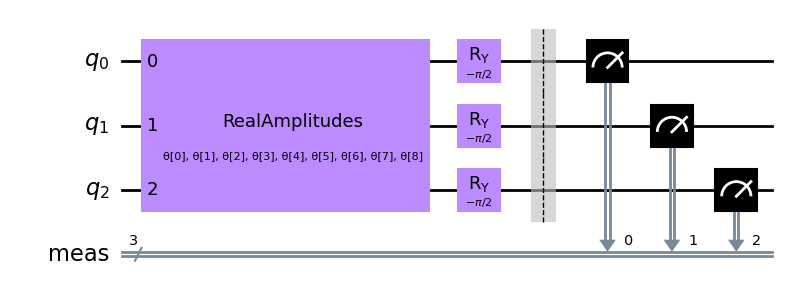

In [13]:
from qiskit.primitives import Sampler 
sampler = Sampler()

circuit = ansatz.compose(qwc_groups_shared_basis_transformation[0])
circuit.measure_all()
circuit.draw('mpl')

In [14]:
result = sampler.run(
    circuit,
    parameters
).result()

In [15]:
quasi_dist = result.quasi_dists
for qdist in quasi_dist:
    # add missing keys
    val = np.array(
        [qdist[k] if k in qdist else 0 for k in range(2**3)]
    )
val

array([7.56552886e-01, 6.94216234e-02, 8.61988297e-03, 3.56321195e-02,
       4.12373614e-03, 2.62146601e-05, 1.96880307e-02, 1.05935506e-01])

In [16]:
values = [  np.dot(ev, val) for ev in qwc_groups_eigenvalues[0]]
values

[0.6237985025087798,
 0.8044884964108419,
 0.7422689803299114,
 0.9031960934118097,
 0.5779690723296775,
 0.6602489211292522,
 0.7404530245346053]

In [17]:
estimator = Estimator()
estimator.run([ansatz]*len(qwc_groups[0]), qwc_groups[0], [parameters]*len(qwc_groups[0])).result()

EstimatorResult(values=array([0.6237985 , 0.8044885 , 0.74226898, 0.90319609, 0.57796907,
       0.66024892, 0.74045302]), metadata=[{}, {}, {}, {}, {}, {}, {}])

In [18]:
len(PD.contraction_index_mapping)

630

In [19]:
len(PD.unique_pauli_strings)

63

In [20]:
groups

NameError: name 'groups' is not defined